## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install wordcloud

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint

from nltk.tokenize import RegexpTokenizer

In [3]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
# pd.set_option('display.max_colwidth', -1)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('complaints.json','r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
df.shape

(78313, 22)

In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                  '_source.complaint_id':'complaint_id',
                  '_source.issue':'issue',
                  '_source.date_received':'date_received',
                  '_source.state':'state',
                  '_source.consumer_disputed':'consumer_disputed',
                  '_source.product':'product',
                  '_source.company_response':'company_response',
                  '_source.company':'company',
                  '_source.submitted_via':'submitted_via',
                  '_source.date_sent_to_company':'date_sent_to_company',
                  '_source.company_public_response':'company_public_response',
                  '_source.sub_product':'sub_product',
                  '_source.timely':'timely',
                  '_source.complaint_what_happened':'complaint_original',
                  '_source.sub_issue':'sub_issue',
                  '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint_original'] = df['complaint_original'].replace(r'^$',np.nan,regex=True)
df[df['complaint_original'].isna()]

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_original,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78304,complaint-public-v2,complaint,3080086,0.0,None,76107,3080086,Applying for a mortgage or refinancing an exis...,2018-11-22T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-11-22T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Other
78305,complaint-public-v2,complaint,3103013,0.0,Older American,863XX,3103013,Closing an account,2018-12-17T12:00:00-05:00,AZ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-18T12:00:00-05:00,None,Other banking product or service,Yes,NaN,Funds not received from closed account,Consent not provided
78306,complaint-public-v2,complaint,3099437,0.0,None,11217,3099437,Managing an account,2018-12-12T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-18T12:00:00-05:00,None,Checking account,Yes,NaN,Deposits and withdrawals,N/A
78307,complaint-public-v2,complaint,3156336,0.0,None,074XX,3156336,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-19T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Other


In [10]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_original"],inplace=True)
df.reset_index(drop=True)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_original,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
21068,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
21069,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
21070,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# # Write your function here to clean the text and remove all the unnecessary elements.
from tqdm.notebook import tqdm
tqdm.pandas()

df['complaint_clean'] = df['complaint_original'].str.lower()
df['complaint_clean'] = df['complaint_clean'].replace(regex=[r'\{(.*?)\}',r'\((.*?)\)',r'\w*\d\w*'], value="")

punctuation = list(set(string.punctuation))


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def process(text):
    text = whitespace_tokenizer(text)
    text = [w for w in text if w not in punctuation]
    return text

df['complaint_clean'] = df['complaint_clean'].progress_apply(process)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [12]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemetize(texts,allowed_postags=['NOUN']):
    doc = nlp(" ".join(texts))
    return ' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags])

df['complaint_clean'] = df['complaint_clean'].progress_apply(lemetize)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [13]:
df = df.reset_index(drop=True)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_clean","complaint_original"]]

In [15]:
df_clean.head(5)

,complaint_clean,complaint_original
0,morning name xxxx xxxx stop bank cardmember se...,Good morning my name is XXXX XXXX and I apprec...
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...
3,xxxx ticket offer ticket reward card informati...,"On XX/XX/2018, while trying to book a XXXX XX..."
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [16]:
df_clean["complaint_length"] = df_clean["complaint_clean"].progress_apply(lambda x: len(x))

  0%|          | 0/21072 [00:00<?, ?it/s]

<ipython-input-16-c431a473cbbd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df_clean['complaint_length'].describe()

count    21072.000000
mean       378.493546
std        431.626970
min          0.000000
25%        141.000000
50%        266.000000
75%        475.000000
max      11562.000000
Name: complaint_length, dtype: float64

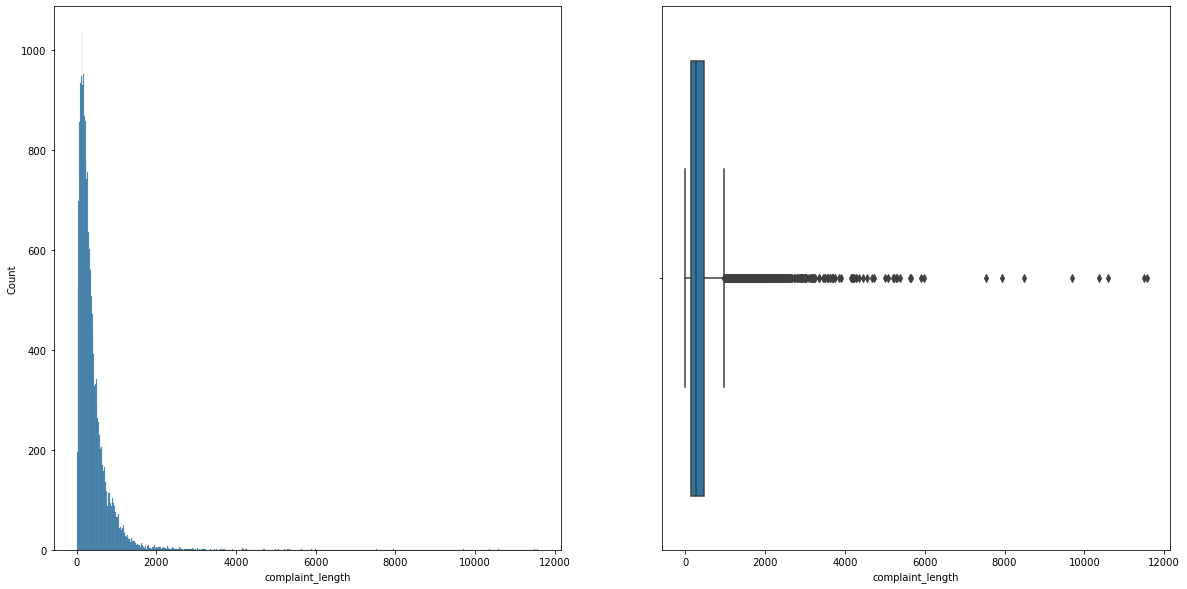

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data=df_clean, x="complaint_length", binwidth=20,ax=ax1)
sns.boxplot(x=df_clean["complaint_length"],ax=ax2)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

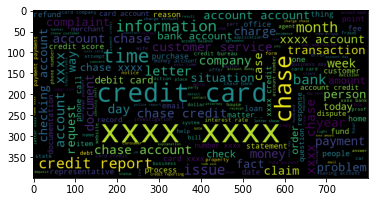

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

complaint_list = df_clean['complaint_clean'].tolist()
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)
complain_text = ' '.join([s for s in complaint_list])
wordcloud.generate(complain_text)
plt.imshow(wordcloud)
plt.show()

In [20]:
# Top 40 words
print(list(wordcloud.words_.keys())[:40])

['xxxx xxxx', 'credit card', 'chase', 'time', 'information', 'credit report', 'issue', 'month', 'bank', 'letter', 'account xxxx', 'customer service', 'xxxx chase', 'company', 'year', 'chase credit', 'account chase', 'chase account', 'day', 'week', 'document', 'money', 'payment', 'account account', 'person', 'charge', 'complaint', 'way', 'xxxx account', 'case', 'request', 'problem', 'fact', 'transaction', 'situation', 'claim', 'checking account', 'bank account', 'amount', 'chase xxxx']


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def compute_freq(sentence, n_value=1):
    tokens = nltk.word_tokenize(sentence)
    ngrams = nltk.ngrams(tokens, n_value)
    ngram_fdist = nltk.FreqDist(ngrams)
    return ngram_fdist
result = compute_freq(complain_text)

In [22]:
#Print the top 10 words in the unigram frequency
result.most_common(10)

[(('xxxx',), 88283),
 (('chase',), 48436),
 (('account',), 46565),
 (('credit',), 32222),
 (('card',), 29450),
 (('payment',), 20968),
 (('bank',), 16846),
 (('time',), 15932),
 (('day',), 12861),
 (('charge',), 11974)]

In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
result = compute_freq(complain_text,2)

In [24]:
#Print the top 10 words in the bigram frequency
result.most_common(10)

[(('xxxx', 'xxxx'), 23872),
 (('credit', 'card'), 12655),
 (('credit', 'report'), 3819),
 (('account', 'xxxx'), 3267),
 (('customer', 'service'), 3054),
 (('xxxx', 'chase'), 3050),
 (('chase', 'credit'), 2975),
 (('account', 'chase'), 2901),
 (('chase', 'account'), 2856),
 (('account', 'account'), 2511)]

In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
result = compute_freq(complain_text,3)

In [26]:
#Print the top 10 words in the trigram frequency
result.most_common(10)

[(('xxxx', 'xxxx', 'xxxx'), 6430),
 (('chase', 'credit', 'card'), 2055),
 (('_', '_', '_'), 1032),
 (('credit', 'card', 'company'), 980),
 (('credit', 'card', 'account'), 968),
 (('xxxx', 'xxxx', 'chase'), 782),
 (('xxxx', 'credit', 'card'), 775),
 (('account', 'xxxx', 'xxxx'), 771),
 (('credit', 'card', 'xxxx'), 728),
 (('credit', 'card', 'chase'), 617)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].replace(regex=r'x{2,}', value="")

<ipython-input-27-f268c7318941>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
#All masked texts has been removed
df_clean.head()

,complaint_clean,complaint_original,complaint_length
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,151
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,120
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,67
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",368
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,165


In [29]:
complaint_list = df_clean['complaint_clean'].tolist()

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(complaint_list)

In [32]:
print(tfidf)

  (0, 2820)	0.21151522166334566
  (0, 82666)	0.20574749103344062
  (0, 17041)	0.2212001570891734
  (0, 21562)	0.17193019614159485
  (0, 42830)	0.17024020715895538
  (0, 26656)	0.19055460228071155
  (0, 54287)	0.20574749103344062
  (0, 50245)	0.2010349119720286
  (0, 26685)	0.2547835352345283
  (0, 8296)	0.19280363964368977
  (0, 79698)	0.1744987384884664
  (0, 87785)	0.2547835352345283
  (0, 26814)	0.22366369878760722
  (0, 76970)	0.2212001570891734
  (0, 13850)	0.17960001095093522
  (0, 55811)	0.24157990654177375
  (0, 54790)	0.22366369878760722
  (0, 39479)	0.0984937090156504
  (0, 2783)	0.1286400610207172
  (0, 82663)	0.12711543490752356
  (0, 15921)	0.03617140701609546
  (0, 21511)	0.08834162753276056
  (0, 42704)	0.06324366915905079
  (0, 54152)	0.06343199512206517
  (0, 50102)	0.08710543487720344
  :	:
  (21071, 61263)	0.10355094852705136
  (21071, 48580)	0.12740500302381913
  (21071, 90723)	0.1313474746718976
  (21071, 1123)	0.21087455408114922
  (21071, 43686)	0.108835872187940

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(
    n_components=num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=40
)

In [35]:
W = nmf_model.fit_transform(tfidf) # Document - topic matrix
H = nmf_model.components_ # Topic - Term matrix

feature_names = tfidf_vectorizer.get_feature_names()

In [36]:
#Print the Top15 words for each of the topics
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 

def topic_table(cmp, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(cmp):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

topic_df = topic_table(
    H,
    feature_names,
    15
)

topic_df.head(15)

,0,1,2,3,4
0,account,card,payment,inquiry,charge
1,check,credit,loan,report,chase
2,bank,credit card,mortgage,credit report,transaction
3,money,chase,chase,credit,dispute
4,fund,chase credit,modification,inquiry credit,claim
5,chase,balance,home,report credit,merchant
6,deposit,account,interest,report inquiry,fraud
7,branch,card credit,month,card inquiry,card
8,account account,card account,time,reporting,email
9,day,score,payment payment,credit inquiry,letter


In [37]:
#Assign the best topic to each of the cmplaints in Topic Column
final = pd.DataFrame(W, columns=[i for i in range(num_topics)])

final['Topic_ind'] = final.apply(lambda x: x.idxmax(), axis=1)
final.head(5)

,0,1,2,3,4,Topic_ind
0,0.007468,0.002514,0.010925,0.004848,0.010224,2
1,0.005928,0.008845,0.002125,0.000101,0.006978,1
2,0.000000,0.022421,0.000000,0.008091,0.001570,1
3,0.012548,0.023294,0.004624,0.032941,0.010453,3
4,0.054003,0.000000,0.000449,0.000000,0.006980,0


In [38]:
df_clean['Topic_ind'] = final['Topic_ind']
df_clean.head(5)

<ipython-input-38-96936d8c981b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_clean,complaint_original,complaint_length,Topic_ind
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,151,2
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,120,1
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,67,1
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",368,3
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,165,0


In [39]:
#Print the first 5 Complaint for each of the Topics
df_clean_grp=df_clean.groupby('Topic_ind').head(5)
df_clean_grp.sort_values('Topic_ind')

,complaint_clean,complaint_original,complaint_length,Topic_ind
12,account code bonus term account deposit bonus...,I opened an account with chase bank on XXXX an...,97,0
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,165,0
6,account debit card branch customer service rep...,With out notice J.P. Morgan Chase restricted m...,592,0
10,account auto,mishandling of this account by Chase auto and ...,17,0
13,concern chase bank overdraft fee alert balance...,"To whom it may concern, Chase bank charged wro...",145,0
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,120,1
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,67,1
21,citizen company time share company refund cre...,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,78,1
9,chase credit card datum credit report company ...,I have a Chase credit card which is incorrectl...,51,1
14,chase amazon card catering order brother funer...,My chase amazon card was declined for a cateri...,539,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [40]:
topic_mapping = {
    0 : "Bank Account services",
    1 : "Credit card or prepaid card",
    2 : "Mortgage/Loan",
    3 : "Others",
    4 : "Theft/Dispute Reporting"
}
df_clean['Topic'] = df_clean['Topic_ind'].map(topic_mapping)

<ipython-input-40-651704e5fc7d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
df_clean.head()

,complaint_clean,complaint_original,complaint_length,Topic_ind,Topic
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,151,2,Mortgage/Loan
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,120,1,Credit card or prepaid card
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,67,1,Credit card or prepaid card
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",368,3,Others
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,165,0,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_original', 'sub_issue', 'consumer_consent_provided',
       'complaint_clean'],
      dtype='object')

In [43]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_original','Topic_ind']]

In [44]:
training_data.head(5)

,complaint_original,Topic_ind
0,Good morning my name is XXXX XXXX and I apprec...,2
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:
#Write your code to get the Vector count
#Write your code here to transform the word vector to tf-idf
X = training_data.complaint_original.values
y = training_data.Topic_ind.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=70)

vectoriser = CountVectorizer()
tfIdfTransformer = TfidfTransformer(use_idf=True)

X_train = vectoriser.fit_transform(X_train)
X_train = tfIdfTransformer.fit_transform(X_train).toarray()

X_test = vectoriser.transform(X_test)
X_test = tfIdfTransformer.transform(X_test).toarray()

In [47]:
y_train

array([4, 4, 2, ..., 4, 4, 0], dtype=int64)

In [48]:
# Distribution of topics in dataset
training_data.Topic_ind.value_counts()

2    5314
0    5236
4    4754
1    4015
3    1753
Name: Topic_ind, dtype: int64

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [49]:
# Write your code here to build any 3 models and evaluate them using the required metrics
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs' , penalty = 'l2')

lr.fit(X_train,y_train)

C:\Users\Supran\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(multi_class='multinomial')

In [50]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC on train : {accuracy_score(y_train,y_pred_train)}')
print(F'ACC on test : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC on train : 0.9634573174348935
ACC on test : 0.9155397390272835
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1054
           1       0.91      0.88      0.89       784
           2       0.93      0.96      0.94      1071
           3       0.90      0.85      0.87       342
           4       0.90      0.91      0.90       964

    accuracy                           0.92      4215
   macro avg       0.91      0.90      0.91      4215
weighted avg       0.92      0.92      0.92      4215



In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=72)
dt.fit(X_train,y_train)
y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC n train: {accuracy_score(y_train,y_pred_train)}')
print(F'ACC n test: {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC n train: 1.0
ACC n test: 0.7753262158956109
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1054
           1       0.76      0.76      0.76       784
           2       0.83      0.83      0.83      1071
           3       0.75      0.75      0.75       342
           4       0.73      0.71      0.72       964

    accuracy                           0.78      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.77      0.78      0.78      4215



In [ ]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier(random_state=72)
params = {
    'max_depth':[2,5,10],
    'min_samples_leaf':[5,10,20],
    'min_samples_split':[5,10,20]
}
grid_search = GridSearchCV(estimator=dt,
            param_grid=params,
            cv=3,
            n_jobs=-1,verbose=10,
            scoring="accuracy")

grid_result = grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [56]:
y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC n train: {accuracy_score(y_train,y_pred_train)}')
print(F'ACC n test: {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC n train: 1.0
ACC n test: 0.7753262158956109
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1054
           1       0.76      0.76      0.76       784
           2       0.83      0.83      0.83      1071
           3       0.75      0.75      0.75       342
           4       0.73      0.71      0.72       964

    accuracy                           0.78      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.77      0.78      0.78      4215



In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [59]:
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC n train: {accuracy_score(y_train,y_pred_train)}')
print(F'ACC n test: {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC n train: 1.0
ACC n test: 0.8230130486358245
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1054
           1       0.80      0.75      0.78       784
           2       0.84      0.90      0.87      1071
           3       0.89      0.71      0.79       342
           4       0.83      0.77      0.80       964

    accuracy                           0.82      4215
   macro avg       0.83      0.80      0.81      4215
weighted avg       0.82      0.82      0.82      4215

